# Simple NN

## Library setup

Disable some console warnings

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Import libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

Define some additional helpers

In [3]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h5 style="text-align: center;">{title}</h5>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [4]:
def get_number_of_tracks(model_label, test_csv = 'data/oct4_MCwithQuantInputs', pred_csv_dir = 'csv'):
    df1 = pd.read_csv(pred_csv_dir + '/' + model_label + '_true.csv')
    headers =  ["true"]
    df1.columns = headers
    df2 = pd.read_csv(pred_csv_dir + '/' + model_label + '_predictionsFiles.csv')
    headers =  ["predicted"]
    df2.columns = headers
    df3 = pd.concat([df1,df2],  axis=1, join="inner")
    dfPT = pd.read_csv(test_csv)
    df5 = pd.concat([df1,df2,dfPT],  axis=1, join="inner")
    df5.to_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv',index=False)
    
    df6=pd.read_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv')
    
    df7 = df6.loc[ (df6['pt'] > 0.2) | (df6['pt'] < -0.2)]
    totalNumberRowsSelected = df7.shape[0] 
    predictedCorrect = df7.loc[ df7['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT = predictedCorrect.shape[0] #first number is number of rows
    newAccuracyMetric = numberCorrectlyPredictedAsHighPT/totalNumberRowsSelected
    
    df8 = df6.loc[ (df6['pt'] > 0.5) | (df6['pt'] < -0.5)]
    totalNumberRowsSelected_halfGeV = df8.shape[0] 
    predictedCorrect_halfGeV = df8.loc[ df8['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_halfGeV = predictedCorrect_halfGeV.shape[0] #first number is number of rows
    newAccuracyMetric_halfGeV = numberCorrectlyPredictedAsHighPT_halfGeV/totalNumberRowsSelected_halfGeV
    
    df9 = df6.loc[ (df6['pt'] > 1) | (df6['pt'] < -1)]
    totalNumberRowsSelected_1GeV = df9.shape[0] 
    predictedCorrect_1GeV = df9.loc[df9['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_1GeV = predictedCorrect_1GeV.shape[0] 
    newAccuracyMetric_1GeV = numberCorrectlyPredictedAsHighPT_1GeV/totalNumberRowsSelected_1GeV

    df10 = df6.loc[ (df6['pt'] > 2) | (df6['pt'] < -2)]
    totalNumberRowsSelected_2GeV = df10.shape[0] 
    predictedCorrect_2GeV = df10.loc[df10['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_2GeV = predictedCorrect_2GeV.shape[0] 
    newAccuracyMetric_2GeV = numberCorrectlyPredictedAsHighPT_2GeV/totalNumberRowsSelected_2GeV

    return (newAccuracyMetric, newAccuracyMetric_halfGeV, newAccuracyMetric_1GeV, newAccuracyMetric_2GeV)

In [5]:
def write_results(filename, model_id, loss, accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0):
    import os
    import csv

    from datetime import datetime
    now = datetime.now()
    date_string = now.strftime("%d/%m/%Y %H:%M:%S")

    f = open(filename, 'a+')
    writer = csv.writer(f)
    if os.stat(filename).st_size == 0:
        writer.writerow(["date", "id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    writer.writerow([date_string, model_id, loss, accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0])
    f.close()

In [6]:
def print_results(filename):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        csv_data = pd.read_csv(filename)
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        #csv_data = csv_data.join(accuracy_avg, on='id', rsuffix='_avg')
        nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        #csv_data = csv_data.join(nt_gev10_avg, on='id', rsuffix='_avg')        
        display(csv_data)

In [7]:
def print_avg_results(filename):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        csv_data = pd.read_csv(filename)
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        csv_avg_data = pd.DataFrame(accuracy_avg)
        csv_avg_data = csv_avg_data.join(nt_gev10_avg, on='id')        
        display(csv_avg_data)

In [8]:
def print_dictionary(d, indent=0):
   for key, value in d.items():
      print('  ' * indent + str(key))
      if isinstance(value, dict):
         print_dictionary(value, indent+1)
      else:
         print('  ' * (indent+1) + str(value))

## Prepare dataset

### Load dataset

Original dataset (aka `dataset 7`)

Balanced dataset (deprecated)

Larger dataset (aka `dataset 6-7-8`). The 14th column is distributed on the range `[0,11]`

In [9]:
dataset = 'quantized6b_'
base_dir = 'data/BigDS_Multiclassifier_Nov15'

df1 = pd.read_csv(base_dir + '/TrainSetWithIntegerYLocalAllUint8.csv')
#df1 = pd.read_csv(base_dir + '/InputTrainSetQuantized.csv')

df2 = pd.read_csv(base_dir + '/TrainSetLabel.csv')

df3 = pd.read_csv(base_dir + '/TestSetWithIntegerYLocalAllUint8.csv')
#df3 = pd.read_csv(base_dir + '/InputTestSetQuantized.csv')

df4 = pd.read_csv(base_dir + '/TestSetLabel.csv')

In [10]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)

Trainig set shape         : (1641960, 14)
Trainig set shape (labels): (1641960, 1)
Test set shape:           : (410488, 14)
Test set shape (labels)   : (410488, 1)


#### Visualize dataset

Observe the span of the value for each of the 14 columns. The 14th column -- if quantized -- should span on the range `[0,11]`.

In [11]:
frames = [df1, df3]

df = pd.concat(frames)

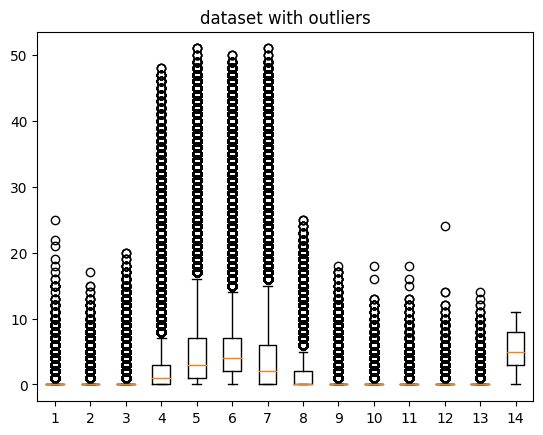

In [12]:
_ = plt.title("dataset with outliers")
_ = plt.boxplot(df.values, showfliers=True)

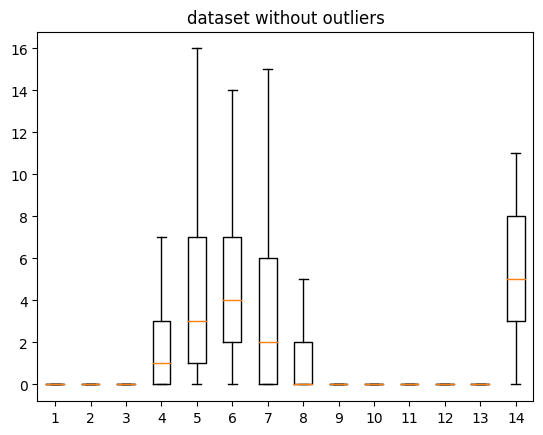

In [13]:
_ = plt.title("dataset without outliers")
_ = plt.boxplot(df.values, showfliers=False)

You should see all integers if you are using the `dataset 6-7-8` with 14th column quantized

In [14]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,3,3,11,12,6,0,0,0,0,0,3
1,0,0,0,0,0,0,6,0,0,0,0,0,0,9
2,0,0,0,9,7,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,1,15,9,0,0,0,0,0,7
4,0,0,0,1,3,4,3,0,0,0,0,0,0,2


In [15]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 51 , log2(max)= 6 , min= 0
X_test: max= 51 , log2(max)= 6 , min= 0


### Scale dataset

Disabling scaling will simplify the hardware design

In [16]:
scale = False

scaling = ''
if scale:
    scaling = 'scaling_'
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
else:
    scaling = 'noscaling_'

#### Visualize dataset post-scaling

In [17]:
pd.DataFrame(X_train).to_csv('csv/' + dataset + scaling + 'InputTrainSetScale.csv',index=False)
pd.DataFrame(X_test).to_csv('csv/' + dataset + scaling + 'InputTestSetScale.csv',index=False)

In [18]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,3,3,11,12,6,0,0,0,0,0,3
1,0,0,0,0,0,0,6,0,0,0,0,0,0,9
2,0,0,0,9,7,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,1,15,9,0,0,0,0,0,7
4,0,0,0,1,3,4,3,0,0,0,0,0,0,2


In [19]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 51 , log2(max)= 6 , min= 0
X_test: max= 51 , log2(max)= 6 , min= 0


### One-hot encoding

In [20]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

y_train_oh.to_csv("csv/" + dataset + "labelsTrainOH.csv",index=False)
y_test_oh.to_csv("csv/" + dataset + "labelsTestOH.csv",index=False)

In [21]:
display_side_by_side(pd.DataFrame(y_test[:5]), pd.DataFrame(y_test_oh[:5]), titles=['Prediction','One-hot encoding'])

Prediction 
 
 
 
 0 
 
 
 
 
 0 
 0 
 
 
 1 
 1 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 0 
 
 
 One-hot encoding 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 1 
 0 
 0 
 
 
 1 
 0 
 1 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 1 
 0 
 0

## Model (Keras)

Let's start with a Keras model that is more traditional and uses floating-point. Our goal is to eventually get a quantized model for QKeras and hls4ml that is _close enough_ to this initial model.

### Model definition

Define a few MLP models with different size and number of layers

In [22]:
models = {}

#### d128

This is our original model that we also use as a reference

In [23]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(128, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d128'] = {
    'prefix': dataset + scaling + 'keras_d128_',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d64

#### d64_d32

#### d32_d32

#### Create and summary

Show the dictionary of models

In [24]:
print_dictionary(models)

d128
  prefix
    quantized6b_noscaling_keras_d128_
  type
    keras
  def
    <function CreateModel at 0x7f7b36bb8d30>


Choose a model for training and testing

In [25]:
chosen_model = 'd128' # <<< PAY ATTENTION <<<

prefix = models[chosen_model]['prefix']
model_def = models[chosen_model]['def']
model_type = models[chosen_model]['type']

In [26]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14)]              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1920      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
relu1 (Activation)           (None, 128)               0         
_________________________________________________________________
dense2 (Dense)               (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,819
Trainable params: 2,563
Non-trainable params: 256
_________________________________________________________

### Model training

In [27]:
train_and_save = False # <<< PAY ATTENTION <<<

In [28]:
model_file = 'models/' + prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                       mode='max', # don't minimize the accuracy!
                       patience=10,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
print(model_file)
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

models/quantized6b_noscaling_keras_d128_model.h5


### Model evaluation

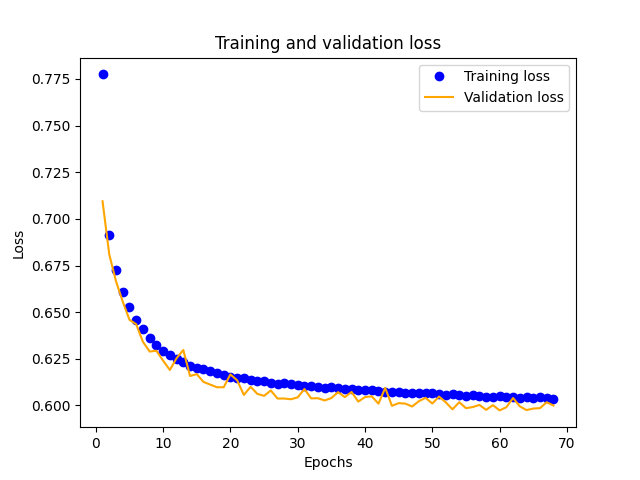

In [29]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

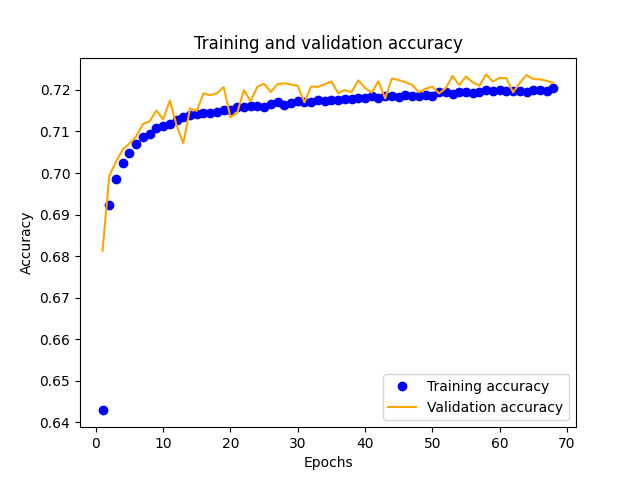

In [30]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [31]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [32]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + prefix + "predictionsFiles.csv", header='predict', index=False)

In [33]:
pd.DataFrame(y_test).to_csv("csv/" + prefix + "true.csv", header='true', index=False)

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))

Test loss (Keras) d128: 0.6035577058792114
Test accuracy (Keras) d128: 0.7218237519264221


Confusion matrix:
[[158114  24542  22588]
 [ 33710  68033    879]
 [ 32084    385  70153]]


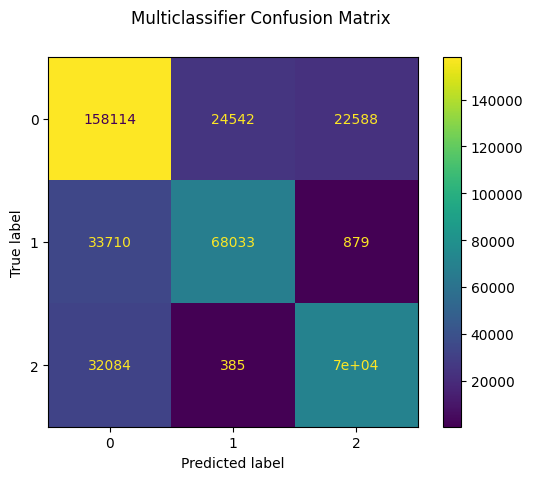

In [35]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

Besides ML accuracy, we can evaluate the model with a metric that is closer to the physical application. We use _the number of tracks that are greater of 1.0 GeV and that are correctly classified as high pT_.

In [36]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'keras_' + chosen_model, base_dir + '/TestSetTruePT.csv')
#GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'keras_' + chosen_model, base_dir + '/trueTestPT.csv')

In [37]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0, '<<<')
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.7703708756407008
- 0.5GeV correctly classified as high pT: 0.8502807835739425
- 1.0GeV correctly classified as high pT: 0.8784468750757888 <<<
- 2.0GeV correctly classified as high pT: 0.8798122065727699
---


Summary of the results.

The model **id** is a label of the kind `dataset_scale_mltype_mlmodel`:
- `datased` can be `origin` (the original dataset) or `quantized6b` (the larger dataset with quantized 14th column)
- `scale` can be `scaling` (use standard scaler) or `noscaling` (don't scale)
- `mltype` can be `keras` (Keras), `qkeras` (QKeras), and `qkeras_foldbatchnorm` (QKeras + patch to fold batch normalization layer in the previous dense layer)
- `mlmodel` can be `d128`, `d64`, etc.

In [38]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    model_id = dataset + scaling + model_type + '_' + chosen_model
    data = pd.DataFrame([[model_id, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,quantized6b_noscaling_keras_d128,0.6036,0.7218,0.7704,0.8503,0.8784,0.8798


Current and previous results

In [39]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, model_id, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0)

In [40]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,23/11/2022 20:05:01,origin_noscaling_keras_d128,0.5537,0.7594,0.8023,0.8509,0.8725,0.8796
1,23/11/2022 20:07:56,origin_noscaling_keras_d128,0.5590,0.7581,0.8031,0.8510,0.8722,0.8770
2,23/11/2022 20:12:03,origin_noscaling_keras_d128,0.5494,0.7601,0.8029,0.8522,0.8736,0.8795
3,23/11/2022 20:14:50,origin_noscaling_keras_d128,0.5570,0.7582,0.8045,0.8522,0.8723,0.8789
4,23/11/2022 20:17:04,origin_noscaling_qkeras_foldbatchnorm_d128,0.5781,0.7461,0.8103,0.8546,0.8745,0.8776
5,23/11/2022 20:19:22,origin_noscaling_keras_d128,0.5548,0.7586,0.8010,0.8495,0.8704,0.8760
6,23/11/2022 20:20:33,origin_noscaling_qkeras_foldbatchnorm_d128,0.5771,0.7465,0.7719,0.8175,0.8356,0.8396
7,23/11/2022 20:49:52,origin_noscaling_keras_d128,0.5466,0.7603,0.8066,0.8533,0.8736,0.8784
8,23/11/2022 20:51:05,origin_noscaling_qkeras_foldbatchnorm_d128,0.5874,0.7404,0.8016,0.8445,0.8620,0.8659
9,23/11/2022 20:54:02,origin_noscaling_keras_d128,0.5552,0.7584,0.8117,0.8595,0.8799,0.8871


Average results so far

In [41]:
print_avg_results(results_filename)

,accuracy,nt_gev10
id,,
origin_noscaling_keras_d128,0.7592,0.8739
origin_noscaling_qkeras_foldbatchnorm_d128,0.7440,0.8598
quantized6b_noscaling_keras_d128,0.7158,0.8800
quantized6b_noscaling_qkeras_foldbatchnorm_d128,0.6746,0.8362


## Model (QKeras)

Mostly the same as the previous section, but now we are usin QKeras

### Model definition

In [42]:
qmodels = {}

#### d128

In [43]:
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     #x = keras.layers.Dropout(0.1)(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model
# qmodels['d128'] = {'prefix': dataset + scaling + 'qkeras_d128_', 'def': CreateQModel}

# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
qmodels['d128'] = {'prefix': dataset + scaling + 'qkeras_foldbatchnorm_d128_', 'type': 'qkeras_foldbatchnorm', 'def': CreateQModel}

#### d64

#### d64_d32

#### d32_d32

#### d128_q6

#### Create and summary

In [44]:
print_dictionary(models)

d128
  prefix
    quantized6b_noscaling_keras_d128_
  type
    keras
  def
    <function CreateModel at 0x7f7b36bb8d30>


In [45]:
chosen_model = 'd128'  # <<< PAY ATTENTION <<<

prefix = qmodels[chosen_model]['prefix']
model_def = qmodels[chosen_model]['def']
model_type = qmodels[chosen_model]['type']

In [46]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense1 (QDenseBatchnorm)     (None, 128)               2433      
_________________________________________________________________
relu1 (QActivation)          (None, 128)               0         
_________________________________________________________________
dense2 (QDense)              (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,820
Trainable params: 2,563
Non-trainable params: 257
_________________________________________________________________


### Model training

In [47]:
train_and_save = False # <<< PAY ATTENTION <<<

In [48]:
model_file = 'models/' + prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
    
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

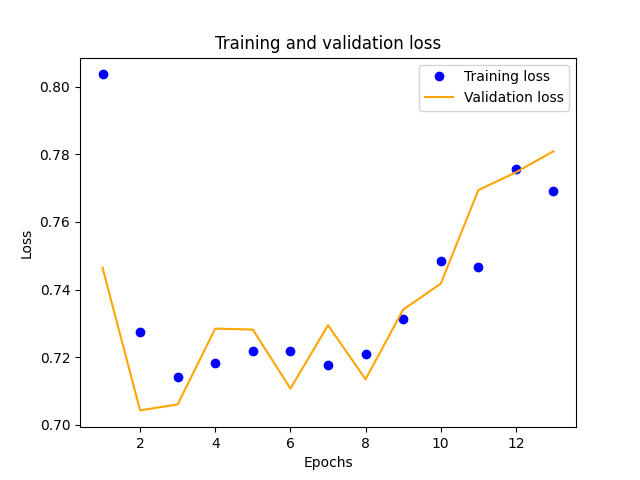

In [49]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

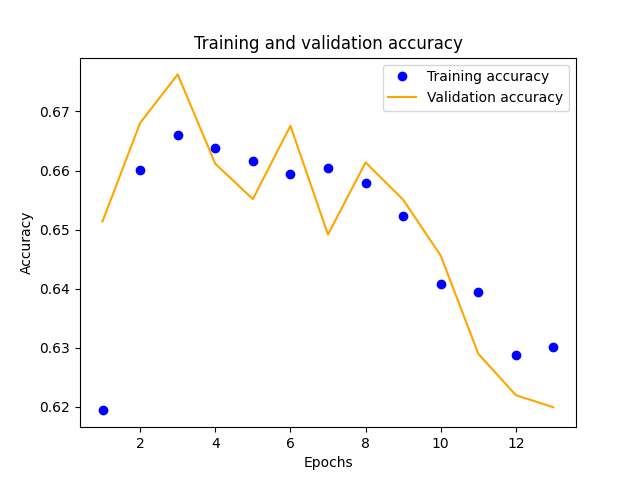

In [50]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [51]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [52]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + prefix + "predictionsFiles.csv", header='predict', index=False)

In [53]:
pd.DataFrame(y_test).to_csv("csv/" + prefix + "true.csv", header='true', index=False)

In [54]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (QKeras) {}: {}".format(chosen_model, score[1]))

Test loss (QKeras) d128: 0.7121071219444275
Test accuracy (QKeras) d128: 0.6732985973358154


Confusion matrix:
[[150622  22843  31779]
 [ 42675  58064   1883]
 [ 34227    700  67695]]


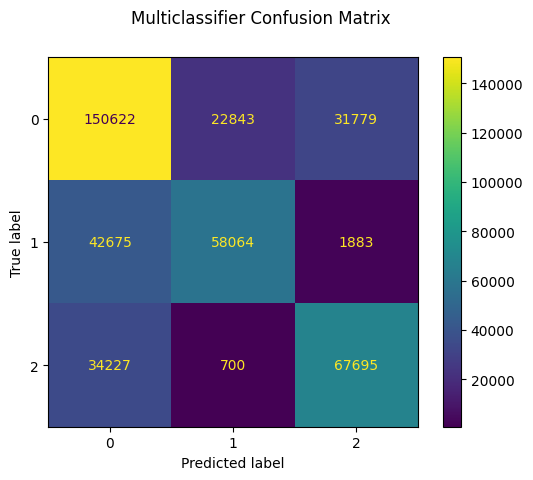

In [55]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

In [56]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'qkeras_foldbatchnorm_' + chosen_model, base_dir + '/TestSetTruePT.csv')
#GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'qkeras_foldbatchnorm_' + chosen_model, base_dir + '/trueTestPT.csv')

In [57]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.7338679815244294
- 0.5GeV correctly classified as high pT: 0.7955214364940044
- 1.0GeV correctly classified as high pT: 0.8166274585889942
- 2.0GeV correctly classified as high pT: 0.8206572769953052
---


In [58]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    model_id = dataset + scaling + model_type + '_' + chosen_model
    data = pd.DataFrame([[model_id, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,quantized6b_noscaling_qkeras_foldbatchnorm_d128,0.7121,0.6733,0.7339,0.7955,0.8166,0.8207


In [59]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, model_id, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0)

In [60]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,23/11/2022 20:05:01,origin_noscaling_keras_d128,0.5537,0.7594,0.8023,0.8509,0.8725,0.8796
1,23/11/2022 20:07:56,origin_noscaling_keras_d128,0.5590,0.7581,0.8031,0.8510,0.8722,0.8770
2,23/11/2022 20:12:03,origin_noscaling_keras_d128,0.5494,0.7601,0.8029,0.8522,0.8736,0.8795
3,23/11/2022 20:14:50,origin_noscaling_keras_d128,0.5570,0.7582,0.8045,0.8522,0.8723,0.8789
4,23/11/2022 20:17:04,origin_noscaling_qkeras_foldbatchnorm_d128,0.5781,0.7461,0.8103,0.8546,0.8745,0.8776
5,23/11/2022 20:19:22,origin_noscaling_keras_d128,0.5548,0.7586,0.8010,0.8495,0.8704,0.8760
6,23/11/2022 20:20:33,origin_noscaling_qkeras_foldbatchnorm_d128,0.5771,0.7465,0.7719,0.8175,0.8356,0.8396
7,23/11/2022 20:49:52,origin_noscaling_keras_d128,0.5466,0.7603,0.8066,0.8533,0.8736,0.8784
8,23/11/2022 20:51:05,origin_noscaling_qkeras_foldbatchnorm_d128,0.5874,0.7404,0.8016,0.8445,0.8620,0.8659
9,23/11/2022 20:54:02,origin_noscaling_keras_d128,0.5552,0.7584,0.8117,0.8595,0.8799,0.8871


In [61]:
print_avg_results(results_filename)

,accuracy,nt_gev10
id,,
origin_noscaling_keras_d128,0.7592,0.8739
origin_noscaling_qkeras_foldbatchnorm_d128,0.7440,0.8598
quantized6b_noscaling_keras_d128,0.7158,0.8800
quantized6b_noscaling_qkeras_foldbatchnorm_d128,0.6746,0.8362


## Hardware translation

### hls4ml configuration

In [ ]:
import hls4ml
import plotting

prefix = 'hls4ml_' + prefix

In [ ]:
print('hls4ml ver.', hls4ml.__version__)

In [ ]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

In [ ]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
#     layers=['Activation'],
#     rounding_mode='AP_RND_CONV',
#     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

hconfig['Model']['Precision'] = 'ap_fixed<16,8>'

# Input
hconfig['LayerName']['input_1']['Precision']['result'] = 'ap_fixed<16,8>'

# Dense
hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<16,8>'
hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<16,8>'

# ReLU
#hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<10,0>'

# Dense
hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<16,8>'
hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<16,8>'

# # ReLU
# #hconfig['LayerName']['relu2']['Precision']['result'] = 'ap_fixed<10,0>'

# # Dense
# hconfig['LayerName']['dense3']['accum_t'] = 'ap_fixed<16,8>'
# hconfig['LayerName']['dense3']['Precision']['result'] = 'ap_fixed<16,8>'

# SoftMax
# #hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'

hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'

# Required for the folding of BatchNormalization
#hconfig['SkipOptimizers'] = ['relu_merge']

for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True

In [ ]:
plotting.print_dict(hconfig)

In [ ]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=prefix + 'vivado_prj',
                                                    part='XC7A100T')

In [ ]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

### Bit-accurate simulation

In [ ]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test))

In [ ]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

In [ ]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join(prefix + 'vivado_prj', 'profiling_{}.png'.format(layer)), dpi=300)

In [ ]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=prefix + 'vivado_prj',
                                                    part='XC7A100T')

hmodel.compile()

In [ ]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test)) 

In [ ]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

In [ ]:
display_side_by_side(pd.DataFrame(X_test[:5]), titles=['Scaled input'])

In [ ]:
display_side_by_side(pd.DataFrame(y_test[:5]),
                     pd.DataFrame(y_test_oh[:5]),
                     pd.DataFrame(preds[:5]),
                     pd.DataFrame(hpreds[:5]),
                     titles=['Expected prediction','Expected prediction (one-hot enc.)', 'QKeras prediction', 'hls4ml prediction'])

### Synthesis

In [ ]:
# This cell applies a patch/workaround necessary with some version of hls4ml.
# It is a poor solution, but it works. Edit patches/project.tcl if you make any change
# in this notebook.
import shutil
_ = shutil.copyfile('patches/project.tcl', prefix + 'vivado_prj/project.tcl')

In [ ]:
%%time
results = hmodel.build(csim=False)

In [ ]:
print('-----------------------------------')
#print(results) # Print hashmap
hls_results=results
#['CSynthesisReport'] 
print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {}, {:0.1f}% (Aval. {})".format(hls_results['BRAM_18K'], int(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {}, {:0.1f}% (Aval. {})".format(hls_results['DSP48E'], int(hls_results['DSP48E'])*100.0/int(hls_results['AvailableDSP48E']), hls_results['AvailableDSP48E']))
print("FF:                     {}, {:0.1f}% (Aval. {})".format(hls_results['FF'], int(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
print("LUT:                    {}, {:0.1f}% (Aval. {})".format(hls_results['LUT'], int(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
#print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
print('-----------------------------------')